This notebook details an analysis of Defensive all team nominations and defensive statistics.

In [1]:
from pandas import read_html
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib as plt
import sklearn
from bs4 import BeautifulSoup
import urllib.request
import numpy as np
import scipy.stats as scipy
import Defensive_Stats as stats
import Defense_All_Team as all_teams
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings

In [2]:
warnings.filterwarnings('ignore')

All data is either pulled from stats.nba.com or basketballreference.com
Data processing and engineering is done in both Defense_all_team.py and Defense_General.py

In [3]:
First_Team,Second_Team = all_teams.get_all_defense()

In [4]:
First_Team.head()
#First_Team.to_csv("First_Team.csv")
#Second_Team.to_csv("Second_Team.csv")

,Player,Year,All_Team
0,Kawhi Leonard,2016.0,1
1,Patrick Beverley,2016.0,1
2,Chris Paul,2016.0,1
3,Draymond Green,2016.0,1
4,Rudy Gobert,2016.0,1


Concatenate the two defensive teams for ease of analysis and visualization

In [5]:
Both_Teams = First_Team.append(Second_Team)

Import the rest of the data

In [6]:
Defensive_Tracking,Defense_General,Shooting,Hustle = stats.Defensive_Stats()

In [7]:
#Player_info = stats.player_stats()
Player_info = pd.read_csv("Player_info.csv")

Create a positions DataFrame to merge with the data later. This is done because comparing across positions may be a futile effort. For example, blocks may be valued more highly for bigs compared with guards

In [8]:
Positions = Player_info.loc[:,['Year','Player','Pos']]
Positions['Year'] = Positions['Year'].astype(float)

Remove the asterisk that exists for some players from the data pulled from basketballreference.com

In [9]:
def asterisk (name):
    if "*" in name:
        return name[:(len(name)-1)]
    else:
        return name

In [10]:
Positions['Player'] = Positions['Player'].apply(asterisk)

Perform an outer join between Defense_General, Shooting DataFrames and Position DataFrame. Null values will represent those players that were not voted into either team. Fill the null values with 0's

In [11]:
Defense_General = pd.merge(Defense_General,Both_Teams, on = ['Year','Player'],how = 'outer')
Defense_General = pd.merge(Defense_General,Positions, on = ['Year','Player'])
Defense_General['All_Team'] = Defense_General['All_Team'].fillna(0)
#Defense_General.to_csv("Defense_General.csv")

In [12]:
Shooting = pd.merge(Shooting,Both_Teams, on = ['Year','Player'],how = 'outer')
Shooting = pd.merge(Shooting,Positions, on = ['Year','Player'])
Shooting['All_Team'] = Shooting['All_Team'].fillna(0)
#Shooting.to_csv("Shooting.csv")

Split the DataFrames into its various positions and remove any possible duplicates.

In [13]:
PG_Defense = Defense_General[Defense_General['Pos'].str.contains("PG")]
SG_Defense = Defense_General[Defense_General['Pos'].str.contains("SG")]
SF_Defense = Defense_General[Defense_General['Pos'].str.contains("SF")]
PF_Defense = Defense_General[Defense_General['Pos'].str.contains("PF")]
C_Defense = Defense_General[Defense_General['Pos'].str.contains("C")]

In [14]:
G_Defense = Defense_General[Defense_General['Pos'].str.contains("G")]
F_Defense = Defense_General[Defense_General['Pos'].str.contains("F")]

In [15]:
PG_Defense.drop_duplicates(inplace=True)
SG_Defense.drop_duplicates(inplace=True)
SF_Defense.drop_duplicates(inplace=True)
PF_Defense.drop_duplicates(inplace=True)
C_Defense.drop_duplicates(inplace=True)
G_Defense.drop_duplicates(inplace=True)
F_Defense.drop_duplicates(inplace=True)

In [16]:
PG_Shooting = Shooting[Shooting['Pos'].str.contains("PG")]
SG_Shooting = Shooting[Shooting['Pos'].str.contains("SG")]
SF_Shooting = Shooting[Shooting['Pos'].str.contains("SF")]
PF_Shooting = Shooting[Shooting['Pos'].str.contains("PF")]
C_Shooting = Shooting[Shooting['Pos'].str.contains("C")]

Looking at the data, there are certain features that might be identified as useless fields in the table.
For example, fields like Player_ID, Team name and Player name can all be dropped.
sklearns Logistic Regression's coefficient array will be used to as a first check for the correlation between features and defensive team nomination. The coefficients may obviously be skewed due to the smaller sample size (20 years)

Also, ranks are chosen over the raw values because different years may cause statistics to be inflated or deflated.

In [17]:
X_all = Defense_General.loc[:,"GP_RANK":"DEF_WS_RANK"]
Y_all = Defense_General['All_Team']

In [18]:
logistic_model = LogisticRegression()
logistic_model.fit(X_all,Y_all)
coeff_df = DataFrame(list(zip(X_all.columns, np.transpose(logistic_model.coef_)[:,0],
                              np.transpose(logistic_model.coef_)[:,1], np.transpose(logistic_model.coef_)[:,2])),
                     columns = ['Feature','No Nomination','First Team','Second Team'])

In [19]:
coeff_df.sort_values(by = "First Team" , ascending = True)

,Feature,No Nomination,First Team,Second Team
4,MIN_RANK,0.017977,-0.026378,-0.008731
12,PCT_BLK_RANK,0.016558,-0.015258,-0.012242
3,W_PCT_RANK,0.007926,-0.013351,-0.003028
10,PCT_STL_RANK,0.013081,-0.012527,-0.008416
8,PCT_DREB_RANK,0.011713,-0.010243,-0.014911
5,DEF_RATING_RANK,0.008201,-0.010101,0.001107
1,W_RANK,0.008219,-0.004654,-0.010569
0,GP_RANK,-0.000868,-0.001060,0.003880
15,OPP_PTS_FB_RANK,-0.001280,-0.000552,0.002092
17,DEF_WS_RANK,0.010455,-0.000225,-0.027566


In [20]:
coeff_df.sort_values(by = "Second Team" , ascending = True).head(10)

,Feature,No Nomination,First Team,Second Team
17,DEF_WS_RANK,0.010455,-0.000225,-0.027566
8,PCT_DREB_RANK,0.011713,-0.010243,-0.014911
12,PCT_BLK_RANK,0.016558,-0.015258,-0.012242
1,W_RANK,0.008219,-0.004654,-0.010569
4,MIN_RANK,0.017977,-0.026378,-0.008731
10,PCT_STL_RANK,0.013081,-0.012527,-0.008416
6,DREB_RANK,0.001462,0.001181,-0.008123
3,W_PCT_RANK,0.007926,-0.013351,-0.003028
13,OPP_PTS_OFF_TOV_RANK,-0.001939,0.003315,-0.001939
16,OPP_PTS_PAINT_RANK,-0.003827,0.005115,-0.001410


In [21]:
coeff_df.sort_values(by = "No Nomination" , ascending = True).head(10)

,Feature,No Nomination,First Team,Second Team
7,DREB_PCT_RANK,-0.012626,0.006408,0.022586
9,STL_RANK,-0.011973,0.011005,0.007879
11,BLK_RANK,-0.010527,0.013134,0.004527
14,OPP_PTS_2ND_CHANCE_RANK,-0.004569,0.002786,0.001447
16,OPP_PTS_PAINT_RANK,-0.003827,0.005115,-0.001410
2,L_RANK,-0.003007,0.002281,0.005094
13,OPP_PTS_OFF_TOV_RANK,-0.001939,0.003315,-0.001939
15,OPP_PTS_FB_RANK,-0.001280,-0.000552,0.002092
0,GP_RANK,-0.000868,-0.001060,0.003880
6,DREB_RANK,0.001462,0.001181,-0.008123


From the analysis above, a few features are standing out to be good indicators for the three categories:
For both first and second team, features such as minutes, win percentage, games played and defensive win shares seem to be the indicators for which players will be nominated into the defensive all team


For non-nominees, features like losses, Opponent 2nd Chance points, Opponent Points in the Paint, Blocks and Steals rank might seem to be the indicators of whether a player gets nominated or not

For the indicators for defensive team players, the features seem to make sense: players who play more games and win more games are often more recognized by the media.

However, for non-nominees, it would seem like those features would also determine a player's defensive prowess. As it turns out, features like Opponent 2nd Chance Points and Opponent Points in the Paint are highly dependent on the minutes played by the player. In addition, steals and blocks are not recorded at the same rate throughout the positions, so it would be a pretty poor indicator if the position the player plays is not known.

In [22]:
def all_team(team):
    if team > 0:
        return 1
    else:
        return 0

Before moving forward, it might be interesting to see how defensive all team nominations in general compare with the rest of the league.

In [23]:
Merged = Defense_General.copy()
Merged['All_Team']= Merged['All_Team'].apply(all_team)

In [24]:
Merged_X = Merged.loc[:,"GP_RANK":"DEF_WS_RANK"]
Merged_Y = Merged['All_Team']

In [25]:
logistic_model1 = LogisticRegression()
logistic_model1.fit(Merged_X,Merged_Y)
coeff_df1 = DataFrame(list(zip(X_all.columns, np.transpose(logistic_model.coef_)[:,0])),
                     columns = ['Feature','Correlation'])

In [26]:

coeff_df1['Correlation_Absolute']= coeff_df1['Correlation'].astype(float).abs()
coeff_df1.sort_values(by= "Correlation_Absolute",ascending = False)

,Feature,Correlation,Correlation_Absolute
4,MIN_RANK,0.017977,0.017977
12,PCT_BLK_RANK,0.016558,0.016558
10,PCT_STL_RANK,0.013081,0.013081
7,DREB_PCT_RANK,-0.012626,0.012626
9,STL_RANK,-0.011973,0.011973
8,PCT_DREB_RANK,0.011713,0.011713
11,BLK_RANK,-0.010527,0.010527
17,DEF_WS_RANK,0.010455,0.010455
1,W_RANK,0.008219,0.008219
5,DEF_RATING_RANK,0.008201,0.008201


Interestingly, Defensive Rating only seems like an average indicator for both teams. This may indicate that nominations for certain positions may correlate more highly with Defensive Rating than other positions.

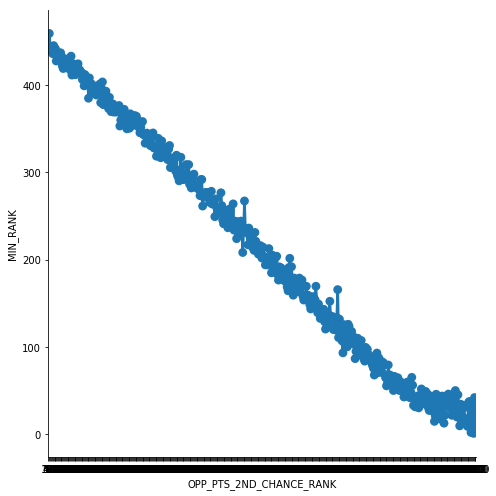

In [27]:
sns.factorplot(x="OPP_PTS_2ND_CHANCE_RANK",y="MIN_RANK",data = Defense_General,ci=0,size=7)

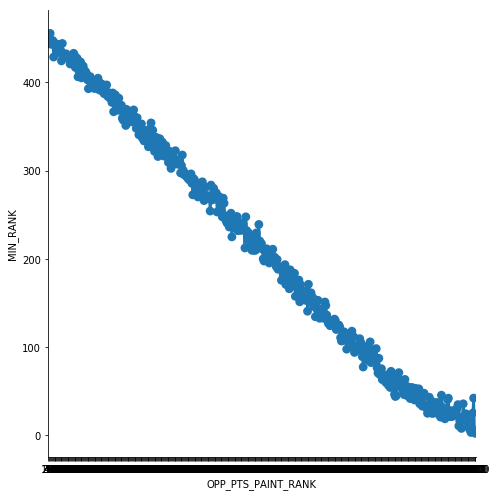

In [28]:
sns.factorplot(x="OPP_PTS_PAINT_RANK",y="MIN_RANK",data = Defense_General,ci=0,size=7)

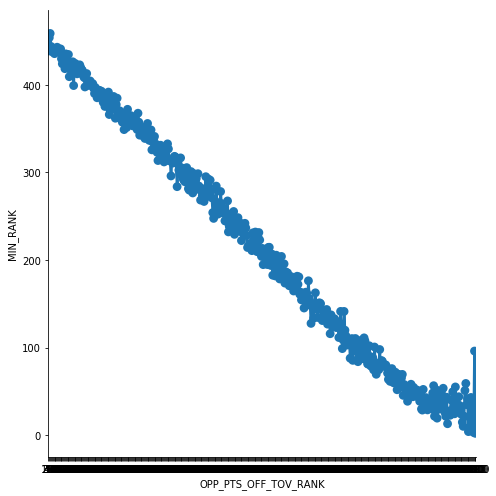

In [29]:
sns.factorplot(x="OPP_PTS_OFF_TOV_RANK",y="MIN_RANK",data = Defense_General,ci=0,size=7)

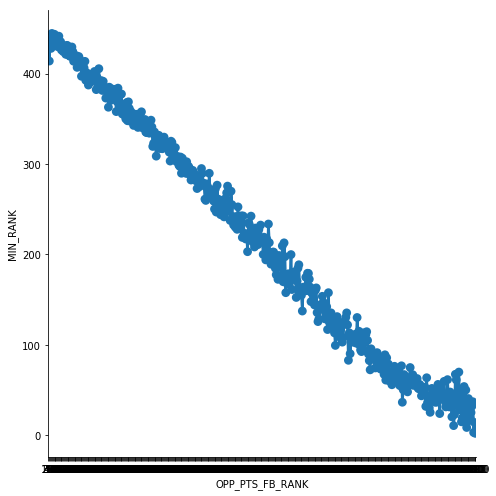

In [30]:
sns.factorplot(x="OPP_PTS_FB_RANK",y="MIN_RANK",data = Defense_General,ci=0,size=7)

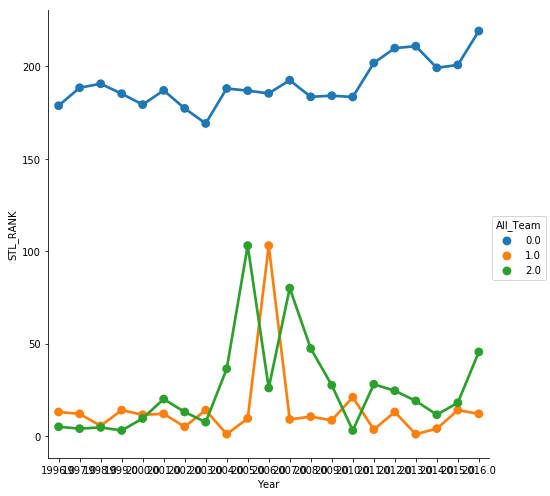

In [31]:
sns.factorplot(x="Year",y="STL_RANK",data = G_Defense,hue="All_Team",ci=0,size=7)

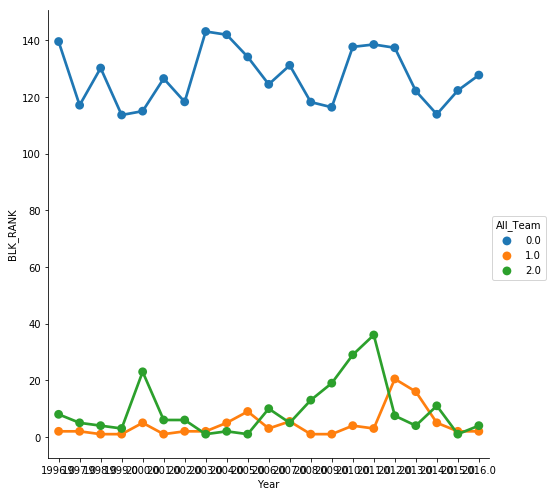

In [32]:
sns.factorplot(x="Year",y="BLK_RANK",data = C_Defense,hue="All_Team",ci=0,size=7)

From the first four graphs, the correlation between the opponent scoring statistics and minutes played can be seen very clearly. Because all team defensive players play more minutes than non nominated players on average, they will let up more points on average in all these situations. A better way to analyze this is perhaps to find the points let up in each situation per minute, to negate the difference in the volume of minutes 

From the last two graphs, as expected, guards who rank the highest in steals are nominated into the defensive teams, while bigs who rank the highest in blocks are nominated in the defensive teams.

In [33]:
Defense_General['OPP_PTS_OFF_TOV_RANK/MIN'] = Defense_General['OPP_PTS_OFF_TOV_RANK']/Defense_General['MIN']
Defense_General['OPP_PTS_2ND_CHANCE_RANK/MIN'] = Defense_General['OPP_PTS_2ND_CHANCE_RANK']/Defense_General['MIN']
Defense_General['OPP_PTS_FB_RANK/MIN'] = Defense_General['OPP_PTS_FB_RANK']/Defense_General['MIN']
Defense_General['OPP_PTS_PAINT_RANK/MIN'] = Defense_General['OPP_PTS_PAINT_RANK']/Defense_General['MIN']

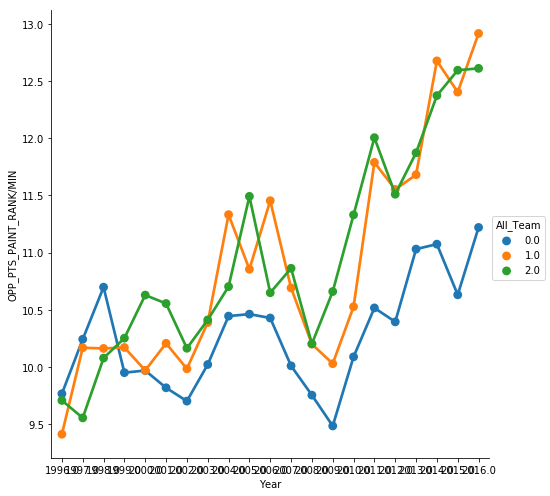

In [34]:
sns.factorplot(x="Year",y="OPP_PTS_PAINT_RANK/MIN",data = Defense_General,hue="All_Team",ci=0,size=7)

After adjusting for minutes played, the stats still seem to lack any indication as to who will make the defensive all teams. One possible explanation for this is that they level of competition is normally higher as they would be playing opposing team starters

Looking at the Defensive Rating feature for different positions might be a good way to see why its not that strong of an indicator

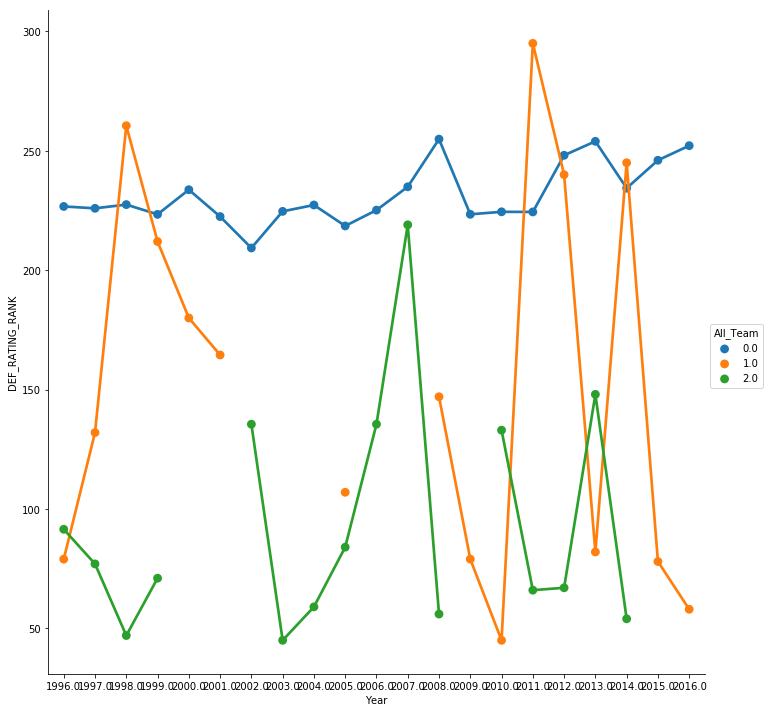

In [35]:
sns.factorplot(x="Year",y="DEF_RATING_RANK",data = PG_Defense,hue="All_Team",ci=0,size=10)

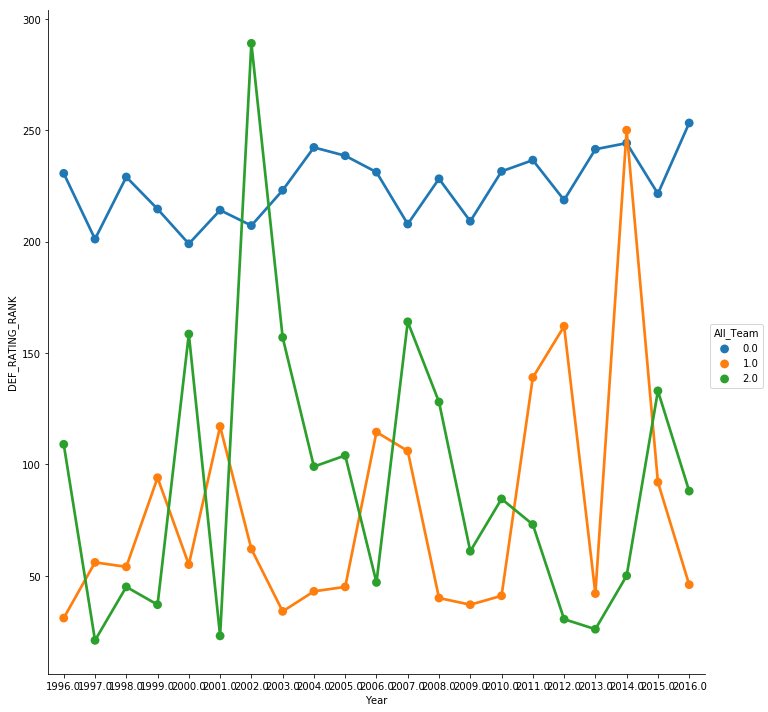

In [36]:
sns.factorplot(x="Year",y="DEF_RATING_RANK",data = C_Defense,hue="All_Team",ci=0,size=10)

It seems that Point Guards' defensive rating is not as correlated to their nomination as Centers'. Two possible hypothesis are that:
1. There are not as many PG's nominated, so the sample size is skewed
2. Defensive impact of bigs are more than points guards, which affects the defensive rating

In [37]:
Second_Team[Second_Team['Year']==2002]

,Player,Year,All_Team
71,Metta World Peace,2002.0,2
72,Bruce Bowen,2002.0,2
73,Jason Kidd,2002.0,2
74,Shaquille O'Neal,2002.0,2
75,Eric Snow,2002.0,2


There are outliers for both positions in terms of Defensive Ratings, but less exist for the bigs. 

The one big spike at 2002 for the centers is Shaq. The Lakers that season had a DefRtg of 104.7, good for 19th in the league.
This is a possible explanation for this outlier, as Shaq might have been dominant despite the Lakers being ranked poorly in Defensive Rating.

One statistic that will be explored in more depth is the Defensive Win Shares stat. Most nominations seem to be on average above the top 50, which suggests its a pretty good metric. Defensive win shares measures the players effect on a teams winning based on his defensive impact. Because it doesn't take into consideration the teams record, players on better teams don't have higher DWS's.

Some metrics are found to be especially good for predicting the nominations of players within a certain position, the following graphs show some of these correlations.

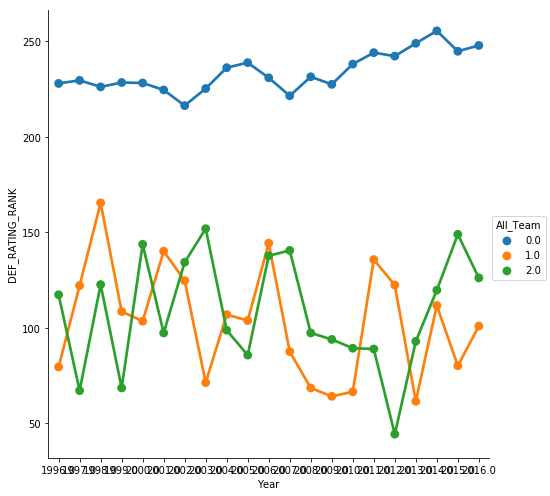

In [38]:
sns.factorplot(x="Year",y="DEF_RATING_RANK",data = Defense_General,hue="All_Team",ci=0,size=7)

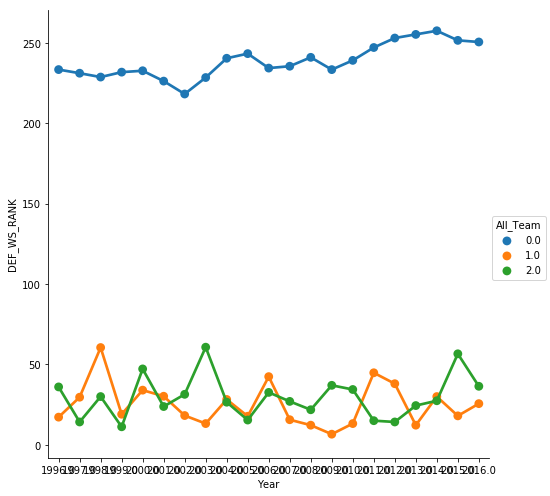

In [39]:
sns.factorplot(x="Year",y="DEF_WS_RANK",data = Defense_General,hue="All_Team",ci=0,size=7)

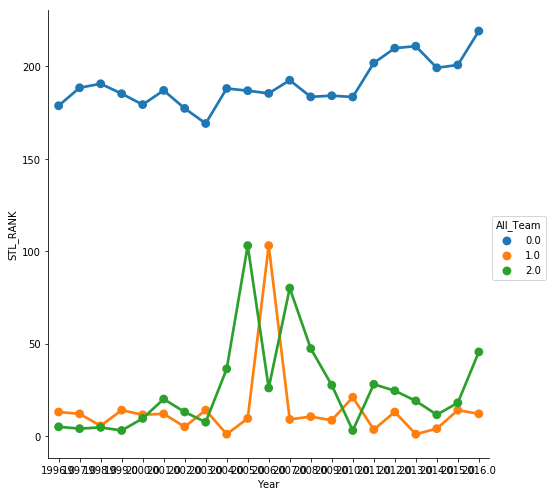

In [40]:
sns.factorplot(x="Year",y="STL_RANK",data = G_Defense,hue="All_Team",ci=0,size=7)

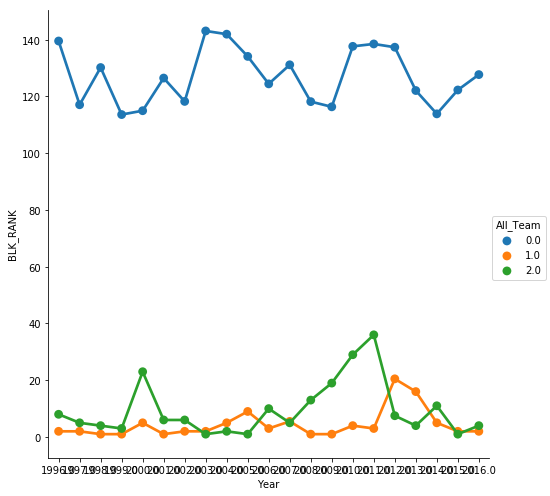

In [41]:
sns.factorplot(x="Year",y="BLK_RANK",data = C_Defense,hue="All_Team",ci=0,size=7)

Any machine learning algorithm will probably overfit given the little amount of data.

The following features are seen to have high correlation with nomination (ignoring position)

1) Minutes: Players who play more minutes get recognized more and play more difficult competition

2) Defensive Win Shares

3) Defensive Rating: Defensive Rating can somewhat measure more intangible aspects of defense like communication or good switching.

4) Wins (or Wins percentage): Players on better teams tend to get more shine from the media

5) Defensive Rebounds: Good defensive rebounders can prevent second chance opportunities and can trigger fast breaks.

The following features are seen to have high correlation with nomination for Guards:

1) Steals: Steals may often result in exciting plays, and are in general a good tell of court awareness and activity. i.e Chris Paul

The following features are seen to have high correlation with nominations of Bigs:

1) Blocks: Blocks are sometimes highlight plays and is an "intimidation factor" for opposing offenses i.e Rudy Gobert

In [ ]:
First_Team = pd.merge(First_Team,Defense_General,on=['Year','Player'])
First_Team = pd.merge(First_Team,Shooting,on = ['Year','Player'])
First_Team = pd.merge(First_Team,Positions,on = ['Year','Player'])
Second_Team = pd.merge(Second_Team,Positions,on = ['Year','Player'])
Second_Team = pd.merge(Second_Team,Defense_General,on=['Year','Player'])
Second_Team = pd.merge(Second_Team,Shooting,on = ['Year','Player'])
Shooting = pd.merge(Shooting,Positions, on = ['Year','Player'])
Defense_General = pd.merge(Defense_General,Positions, on = ['Year','Player'])

Shooting.to_csv("Shooting.csv")
Defense_General.to_csv("Defense_General.csv")
First_Team.to_csv("First_Team.csv")
Second_Team.to_csv("Second_Team.csv")
Player_info.to_csv("Player_info.csv")

In [ ]:
PG_First_Team = First_Team[First_Team['Pos'].str.contains("PG")].loc[:,['Year','Less than 5 Ft FGM',
       'Less than 5 Ft FGA', 'Less than 5 Ft FG%', '5-9 Ft GM', '5-9 Ft FGA',
       '5-9 Ft FG%', '10-14 Ft FGM', '10-14 Ft FGA', '10-14 Ft FG%',
       '15-19 Ft FGM', '15-19 Ft FGA', '15-19 Ft FG%', '20-24 Ft FGM',
       '20-24 Ft FGA', '20-24 Ft FG%', '25-29 Ft FGM', '25-29 Ft FGA',
       '25-29 Ft FG%']]
SG_First_Team = First_Team[First_Team['Pos'].str.contains("SG")].loc[:,['Year','Less than 5 Ft FGM',
       'Less than 5 Ft FGA', 'Less than 5 Ft FG%', '5-9 Ft GM', '5-9 Ft FGA',
       '5-9 Ft FG%', '10-14 Ft FGM', '10-14 Ft FGA', '10-14 Ft FG%',
       '15-19 Ft FGM', '15-19 Ft FGA', '15-19 Ft FG%', '20-24 Ft FGM',
       '20-24 Ft FGA', '20-24 Ft FG%', '25-29 Ft FGM', '25-29 Ft FGA',
       '25-29 Ft FG%']]
SF_First_Team = First_Team[First_Team['Pos'].str.contains("SF")].loc[:,['Year','Less than 5 Ft FGM',
       'Less than 5 Ft FGA', 'Less than 5 Ft FG%', '5-9 Ft GM', '5-9 Ft FGA',
       '5-9 Ft FG%', '10-14 Ft FGM', '10-14 Ft FGA', '10-14 Ft FG%',
       '15-19 Ft FGM', '15-19 Ft FGA', '15-19 Ft FG%', '20-24 Ft FGM',
       '20-24 Ft FGA', '20-24 Ft FG%', '25-29 Ft FGM', '25-29 Ft FGA',
       '25-29 Ft FG%']]
PF_First_Team = First_Team[First_Team['Pos'].str.contains("PF")].loc[:,['Year','Less than 5 Ft FGM',
       'Less than 5 Ft FGA', 'Less than 5 Ft FG%', '5-9 Ft GM', '5-9 Ft FGA',
       '5-9 Ft FG%', '10-14 Ft FGM', '10-14 Ft FGA', '10-14 Ft FG%',
       '15-19 Ft FGM', '15-19 Ft FGA', '15-19 Ft FG%', '20-24 Ft FGM',
       '20-24 Ft FGA', '20-24 Ft FG%', '25-29 Ft FGM', '25-29 Ft FGA',
       '25-29 Ft FG%']]
C_First_Team = First_Team[First_Team['Pos'].str.contains("C")].loc[:,['Year','Less than 5 Ft FGM',
       'Less than 5 Ft FGA', 'Less than 5 Ft FG%', '5-9 Ft GM', '5-9 Ft FGA',
       '5-9 Ft FG%', '10-14 Ft FGM', '10-14 Ft FGA', '10-14 Ft FG%',
       '15-19 Ft FGM', '15-19 Ft FGA', '15-19 Ft FG%', '20-24 Ft FGM',
       '20-24 Ft FGA', '20-24 Ft FG%', '25-29 Ft FGM', '25-29 Ft FGA',
       '25-29 Ft FG%']]
PG_Second_Team = Second_Team[Second_Team['Pos'].str.contains("PG")].loc[:,['Year','Less than 5 Ft FGM',
       'Less than 5 Ft FGA', 'Less than 5 Ft FG%', '5-9 Ft GM', '5-9 Ft FGA',
       '5-9 Ft FG%', '10-14 Ft FGM', '10-14 Ft FGA', '10-14 Ft FG%',
       '15-19 Ft FGM', '15-19 Ft FGA', '15-19 Ft FG%', '20-24 Ft FGM',
       '20-24 Ft FGA', '20-24 Ft FG%', '25-29 Ft FGM', '25-29 Ft FGA',
       '25-29 Ft FG%']]
SG_Second_Team = Second_Team[Second_Team['Pos'].str.contains("SG")].loc[:,['Year','Less than 5 Ft FGM',
       'Less than 5 Ft FGA', 'Less than 5 Ft FG%', '5-9 Ft GM', '5-9 Ft FGA',
       '5-9 Ft FG%', '10-14 Ft FGM', '10-14 Ft FGA', '10-14 Ft FG%',
       '15-19 Ft FGM', '15-19 Ft FGA', '15-19 Ft FG%', '20-24 Ft FGM',
       '20-24 Ft FGA', '20-24 Ft FG%', '25-29 Ft FGM', '25-29 Ft FGA',
       '25-29 Ft FG%']]
SF_Second_Team = Second_Team[Second_Team['Pos'].str.contains("SF")].loc[:,['Year','Less than 5 Ft FGM',
       'Less than 5 Ft FGA', 'Less than 5 Ft FG%', '5-9 Ft GM', '5-9 Ft FGA',
       '5-9 Ft FG%', '10-14 Ft FGM', '10-14 Ft FGA', '10-14 Ft FG%',
       '15-19 Ft FGM', '15-19 Ft FGA', '15-19 Ft FG%', '20-24 Ft FGM',
       '20-24 Ft FGA', '20-24 Ft FG%', '25-29 Ft FGM', '25-29 Ft FGA',
       '25-29 Ft FG%']]
PF_Second_Team = Second_Team[Second_Team['Pos'].str.contains("PF")].loc[:,['Year','Less than 5 Ft FGM',
       'Less than 5 Ft FGA', 'Less than 5 Ft FG%', '5-9 Ft GM', '5-9 Ft FGA',
       '5-9 Ft FG%', '10-14 Ft FGM', '10-14 Ft FGA', '10-14 Ft FG%',
       '15-19 Ft FGM', '15-19 Ft FGA', '15-19 Ft FG%', '20-24 Ft FGM',
       '20-24 Ft FGA', '20-24 Ft FG%', '25-29 Ft FGM', '25-29 Ft FGA',
       '25-29 Ft FG%']]
C_Second_Team = Second_Team[Second_Team['Pos'].str.contains("C")].loc[:,['Year','Less than 5 Ft FGM',
       'Less than 5 Ft FGA', 'Less than 5 Ft FG%', '5-9 Ft GM', '5-9 Ft FGA',
       '5-9 Ft FG%', '10-14 Ft FGM', '10-14 Ft FGA', '10-14 Ft FG%',
       '15-19 Ft FGM', '15-19 Ft FGA', '15-19 Ft FG%', '20-24 Ft FGM',
       '20-24 Ft FGA', '20-24 Ft FG%', '25-29 Ft FGM', '25-29 Ft FGA',
       '25-29 Ft FG%']]